### Transfer learning 
Training a neural network on traffic images to perform binary classification as:<br>
1) **medium** congested, classified as label **1**.<br>
2) **low** congested, classified as label **0**.<br>

Here we are using [Keras](https://github.com/keras-team/keras) with [TensorFlow](https://www.tensorflow.org/) backend to demostrate transfer learning on the [traffic images API](https://api.data.gov.sg/v1/transport/traffic-images) to classify images.
Training is first done on 9 images each from each class, then we 'freeze' the *feature layers* and rebuild the model to classify the remaining images.

After 87 images were scrapped each time from the [API](https://api.data.gov.sg/v1/transport/traffic-images) on 2 different times of the day - assuming one was during **peak time** and other was during **off-peak**, they had to be manually labelled.<br>

Images have been split to train and test (validation) set in the data folder. <br>

#### Import packages
Source: https://github.com/keras-team/keras/blob/master/examples/mnist_transfer_cnn.py

In [106]:
#from env py35
import datetime
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from PIL import Image
import os
from random import shuffle
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

We will be using this later to record how long it takes to train our model.

In [79]:
now = datetime.datetime.now
print (now())

2018-12-24 22:45:27.947866


#### Instantiation of hyperparameters

Here we instantiate the values of hyperparameters that we will be using later. We will stick to the parameters similar to the deep neural network except for the `epochs` which is reduced, as CNN are more computationally expensive.

Some terms to define for my [reference](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9):<br>
1) `batch_size`: total # of training examples present in the dataset<br>
2) `number of batches`: # of sets/parts a dataset is divided.<br>
3) `iterations`: # of batches needed to complete one epoch. AKA number of batches.<br>
4) `epoch`: when an entire dataset is passed once, forward and backward through the neural network.

We have 18 images in the training data. <br>
Batch size of 3 images are to be passed in 6 iterations/number of batches for one epoch.<br>
OR <br>
Batch size of 6 images are to be passed in 3 iterations/number of batches for one epoch.

In [80]:
# I will go with the first choice for the trial
batch_size = 3
num_classes = 6
epochs = 6

The sizes differ for the images and they should be of the same dimensions.

#### Image Information
As the scrapped data is not labelled, I decided which images to be considered as medium congestion and low congestion. The test data has a 50-50 balance of the medium vs low congestion.
Now, I would need to label the images as such that the image is labelled as class `0` or `1`.

In [81]:
DIR = './data/train'

# First, I need to figure how I should format the height x width image dimensions
# to input to a keras model
def get_img_statistics():
    heights = []
    widths = []
    img_count = 0
    for img in os.listdir(DIR):
        path = os.path.join(DIR, img)
        if "DS_Store" not in path:
            data = np.array(Image.open(path))
            heights.append(data.shape[0])
            widths.append(data.shape[1])
            img_count += 1
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

get_img_statistics()

Average Height: 458.6666666666667
Max Height: 480
Min Height: 288


Average Width: 611.5555555555555
Max Width: 640
Min Width: 384


The sizes differ for the images and they should be of the same dimensions.

#### Labelling image data
As the scrapped data is not labelled, I decided which images to be considered as medium congestion and low congestion. The test data has a 50-50 balance of the medium vs low congestion.
Now, I would need to label the images as such that the image is labelled as class **`0, 1` for low congestion** or **`1, 0` for medium congestion**.

In [82]:
def label_img(img_name):
    
    img_name = img_name.split('.')[0]
    
    if img_name.endswith('c'): 
        return np.array([1, 0])
    elif img_name.endswith('n'): 
        return np.array([0, 1])
    else:
        return print ('Photo has not been labelled as congested or non-congested.')

#### Image formatting 
Images that are used as inputs in a Keras model must be formatted. Therefore the input dimensions are specified, as the dimensions of all the images differ vastl, so that the images are uniform before the model is trained on these images.

In [83]:
img_size = 300

def load_training_data():
    train_data = []
    for img in os.listdir(DIR):
        label = label_img(img)
        path = os.path.join(DIR, img)
        if "DS_Store" not in path:
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((img_size, img_size), Image.ANTIALIAS)
            train_data.append([np.array(img), label])
            
    shuffle(train_data)
    return train_data

In [84]:
#list object
train_data = load_training_data()

In [90]:
#list item has 2 items: 1) the array, 2)the label
len(train_data[4])

2

In [89]:
train_data[4]

[array([[252, 253, 252, ...,  16,  22,  20],
        [253, 252, 255, ...,  20,  17,  10],
        [252, 253, 253, ...,  19,   9,   6],
        ...,
        [ 29,  42,  51, ...,  64,  63,  65],
        [ 32,  41,  40, ...,  64,  63,  63],
        [ 32,  43,  39, ...,  64,  63,  62]], dtype=uint8), array([0, 1])]

In [93]:
train_data[4][0]

array([[252, 253, 252, ...,  16,  22,  20],
       [253, 252, 255, ...,  20,  17,  10],
       [252, 253, 253, ...,  19,   9,   6],
       ...,
       [ 29,  42,  51, ...,  64,  63,  65],
       [ 32,  41,  40, ...,  64,  63,  63],
       [ 32,  43,  39, ...,  64,  63,  62]], dtype=uint8)

In [92]:
train_data[4][1]

array([0, 1])

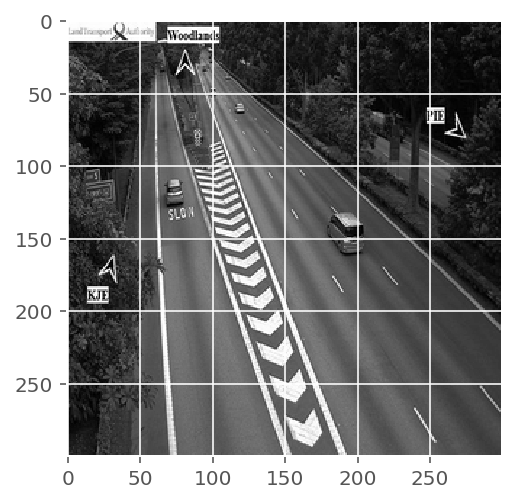

In [87]:
plt.imshow(train_data[4][0], cmap = 'gist_gray')

#### Assembling a simple CNN
I will be using one-hot vector encoding as it produces better result than encoding each label with ‘0’ or ‘1’.

In [99]:
#array object
#collate all images after reshaping
train_images = np.array([i[0] for i in train_data]).reshape(-1, img_size, img_size, 1)
#collate all labels
train_labels = np.array([i[1] for i in train_data])

In [108]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2, activation = 'softmax'))

In [109]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [111]:
#verbose=1 will show you an animated progress bar 
model.fit(train_images, train_labels, batch_size = batch_size, epochs = 6, verbose = 1) #batch_size = 50, epochs = 5 

Epoch 1/6
18/18 [==============================] - 3s 194ms/step - loss: 0.4579 - acc: 0.8889
Epoch 2/6
18/18 [==============================] - 4s 198ms/step - loss: 0.3343 - acc: 0.8889
Epoch 3/6
18/18 [==============================] - 4s 231ms/step - loss: 0.2791 - acc: 0.9444
Epoch 4/6
18/18 [==============================] - 4s 205ms/step - loss: 0.0487 - acc: 1.0000
Epoch 5/6
18/18 [==============================] - 4s 204ms/step - loss: 0.0028 - acc: 1.0000
Epoch 6/6
18/18 [==============================] - 4s 215ms/step - loss: 0.0043 - acc: 1.0000


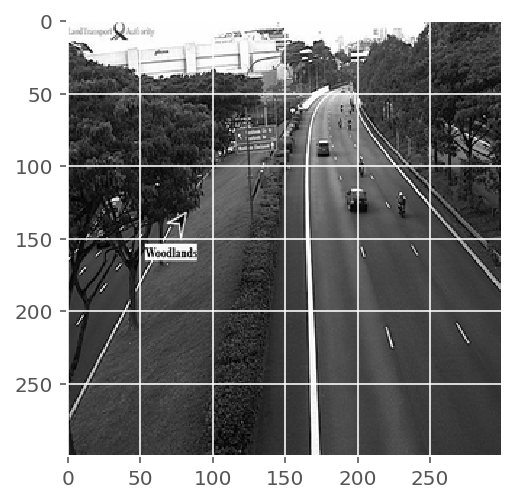

In [113]:
# Test on Test Set
TEST_DIR = './data/validation'
def load_test_data():
    test_data = []
    for img in os.listdir(TEST_DIR):
        label = label_img(img)
        path = os.path.join(TEST_DIR, img)
        if "DS_Store" not in path:
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((img_size, img_size), Image.ANTIALIAS)
            test_data.append([np.array(img), label])
    shuffle(test_data)
    return test_data


test_data = load_test_data()    
plt.imshow(test_data[2][0], cmap = 'gist_gray')

In [115]:
test_images = np.array([i[0] for i in test_data]).reshape(-1, img_size, img_size, 1)
test_labels = np.array([i[1] for i in test_data])

loss, acc = model.evaluate(test_images, test_labels, verbose = 0)
print(acc * 100)

77.77777910232544
